# Pre-content: Planning

- Reference and do not repeat on: [Friedrich's ed stuff](https://github.com/ooi-data-review/2018-data-workshops/blob/master/physics/examples/Example%2002%20-%20Using%20the%20OOI%20API%20with%20Python.ipynb)
- Take a look at [Keenan's work](https://github.com/cormorack/notebooks/blob/master/dev_notebooks/keenan/DO%20vs.%20Temperature%20vs.%20Nitrate.ipynb)
as well with Don
- Bridge back to portal: Recreate this chart
- App mode available? Turns the code on/off; is this part of JupyterLab
- Affirmation: Having the code present is a key element of 'feasibility argument'
- Time series chlorophyll as complementary courtesy NASA/CMR: Profiler let's us translate that down thru 200 meters
- Technical challenge: Data presistence/volume. Address by May 30; possibly with some zarr 
- Gallery to cormorack org; work in a dev branch
- Start communication strategy
- More in situo: gliders, surface stations, tethered; again with emphasis on chlorophyll
- Teaching 'resolve separately timed observations' is very endorsed as super valuable
- Looking for guidance in terms of what we want to see
- Susan (instructor for OCNG-200 physical ocng course) to get feedback
- Hunter: can use accordion windows to hide code
- Might be good to get Friedrich’s feedback given previous education experience
- Needed here:
  - MODIS Chlor-A
  - whale call at top on Play button
  - Less lurid color schemes for GLODAP
  - Compare the glodap temperature difference by overlaying a glodap temperature profile 'nearest' and include in observations
  - Clean up the ARGO inclusion and add a GLODAP; this should be a separate dedicated comparative chart


# Ocean Science

<img src="./humpback.png" style="float: left;" alt="drawing" width="500"/>
<div style="clear: left"><BR>

The ocean is full of water, true, but it also contains dissolved oxygen and and nitrates and chlorophyll and carbonates 
as well as heat and light; all varying with depth and time and latitude 
and longitude, not to mention that of course there are whales. Whales and volcanoes
and shipwrecks and coral reefs and so on. Ocean science considers the ocean as a 
vast system of interacting components. The challenge is understanding how they fit together. 


The interested reader is here invited to think (deeply...) about the ocean through the lens of data: Measurements that 
we make via automated sensors on a time scale of seconds. We consider for the moment the upper 200 meters of the ocean. 


Why 200 meters particularly? First because 200 meters is as deep as sunlight can hope to penetrate into the
ocean; sunlight being the energy supply for biological production of sugar (photosynthesis). The upper layer
of water contains the bulk of the ocean's biological production engine. Attuned to this idea we find
that the Regional Cabled Observator (RCO) supports a network of profilers -- human-built observing pods about 
the size of a laundry basket -- that periodically rise and fall through the water column. Here is a chart showing 
ascent and descent cycles of two such pods over 24 hours: A deep profiler (green) and a shallow profiler (red) 
located near one another on the continental shelf off of Oregon. Notice the shallow profiler ascends
from 200 meters depth to near the surface nine times in the course of a single day. 


<img src="../data/images/profilers_depth_24_hours.png" style="float: left;" alt="drawing" width="700"/>
<div style="clear: left">


<BR>
This notebook concerns data from a shallow profiler where we hope to...

</div>

- obtain data, analyze it { depth, temperature, available light, salinity, dissolved oxygen, nitrate, carbon dioxide, chlorophyll, pH }
- compare these measurements to measurements from other resources


### Related Links 

- [RCO data access notebook](https://github.com/cormorack/yodapy/tree/master/examples)
- [Interactive oceans engineering page](https://interactiveoceans.washington.edu/oms_data/) (click **Profiler Summary**)

In [40]:
%matplotlib inline
!pip install utm
!pip install pygeotools
import timeit, pandas as pd, netCDF4, xarray as xr, dask, numpy as np, sys, os, utm, golive_utility as g
from datetime import timedelta, datetime
from matplotlib import pyplot as plt, dates as mdates
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri
from ipywidgets import *
from traitlets import dlink
from mpl_toolkits.mplot3d import Axes3D
np.warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### a global ocean snapshot

The three maps that follow show most of the earth's oceans in terms of oxygen, salinity and temperature. 
These are sliced by depth; so for each map you can move the depth slider to examine a particular slice.
The depth you are viewing is shown on the map at the lower left; and the deeper slices extend below
the sea floor over much of the earth; so there is no data. 

In [70]:
S=xr.open_dataset('data/gsal.nc'); T = xr.open_dataset('data/gtemp.nc'); O = xr.open_dataset('data/gO2.nc')
plt.rcParams.update({'font.size': 20})

def pO2(depth_index):
    O['oxygen'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=plt.cm.bwr_r,vmin=150, vmax=350)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else:                msg += 'water at ' + str(int(O['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(28, 50, 'oxygen dissolved in'); plt.text(28, 42, '     ocean water   ')
    
def pSal(depth_index):
    S['salinity'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=plt.cm.brg,vmin=33, vmax=36)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(S['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'salinity of'); plt.text(47, 42, 'ocean water')

def pTemp(depth_index):
    T['temperature'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=plt.cm.gist_rainbow_r,vmin=2., vmax=10.)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(T['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'temperature of'); plt.text(47, 42, 'ocean water')

interact(pO2,   depth_index=widgets.IntSlider(min=0,max=32,step=1,value=5,  continuous_update=False, description='depth'))
interact(pSal,  depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0,  continuous_update=False, description='depth'))
interact(pTemp, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=13, continuous_update=False, description='depth')) 

interactive(children=(IntSlider(value=5, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=13, continuous_update=False, description='depth', max=32), Output()), _d…

<function __main__.pTemp>

In [71]:
from ipyleaflet import WMSLayer, Map
m = Map(center=(46.0, -130.0), zoom=10)
m.add_layer(WMSLayer(url="http://52.41.106.186:8080/geoserver/ows?", layers="bmpyramid:CAVA_Bathymetry", \
                     format="image/png", transparent=True, opacity=0.7))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### searching for and requesting data

This code is the basis for requesting data from the Ocean Observing Initiative data archive.

```
from yodapy.datasources import OOI
ooi = OOI() 
ooi.view_sites()                        
ooi.search(region='cabled', site='oregon slope base shallow profiler', instrument='spectral', node='profiler')
ooi.view_instruments()
myDataRequest = ooi.request_data(begin_date='2017-08-21', end_date='2017-08-22')
```

A key idea is using an object (called `ooi`) that has a built-in filter. One narrows the filter
settings down before requesting data. Further details are covered in the science notebooks. 


Data files for one day range from 30 observations to over 100,000. 
As noted above there are nine profiles per day made by the 'shallow profiler'
(see red line in the chart at the top).


In what follows we consider eight types of data

- From the **CTD** instrument (one measurement per second)
  - depth (as pressure in decibars, corresponding closely to meters below the surface)
  - temperature (deg Celsius)
  - salinity (as 'practical salinity units' which is close to parts per thousand salt concentration)
  - dissolved oxygen (important to zooplankton and other heterotrophs)
- From the **pH** instrument (30 measurements per day)
  - pH (in the case of the ocean alkalinity, greater than 7.0
- From the **nitrate** instrument (about two measurements per minute)
  - nitrate concentration, measured only during the midnight and noon profiles (not the other seven)
- From the **Photosynthetically Active Radiation (PAR)** sensor; measuring about three times per second
  - PAR count
- From the **Fluorometer**, measured about once per second
  - Chlorophyll concentration inferred by fluorescence
- From the **Spectral Irradiance** instrument; several times per second
  - Ambient light levels for seven distinct wavelengths

In [72]:
ctdF     = xr.open_dataset('data/osb_shallow_ctd.nc');
phF      = xr.open_dataset('data/osb_shallow_ph.nc');
nitrateF = xr.open_dataset('data/osb_shallow_nitrate.nc');
parF     = xr.open_dataset('data/osb_shallow_par.nc');
fluorF   = xr.open_dataset('data/osb_shallow_fluor.nc');
siF      = xr.open_dataset('data/osb_shallow_si0.nc'); 

### data volume reductions steps

- need to apply to ctd (notice indexing will change from [:, 0]) x 4
- then PAR
- then nitrate
- then pH
- then fluor

And then all of the loads and modifications and crossovers given below should be simplified down as they 
are mostly no longer necessary; but capture the code. 


```
q=siF.spkir_downwelling_vector[:,0].to_dataset(name='si0')
q.coords['time'] = ('time', q.time)
q['si0']=(('time'), q.si0)
q.drop('obs')
q=q.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
q.to_netcdf('data/osb_shallow_si0.nc')
```

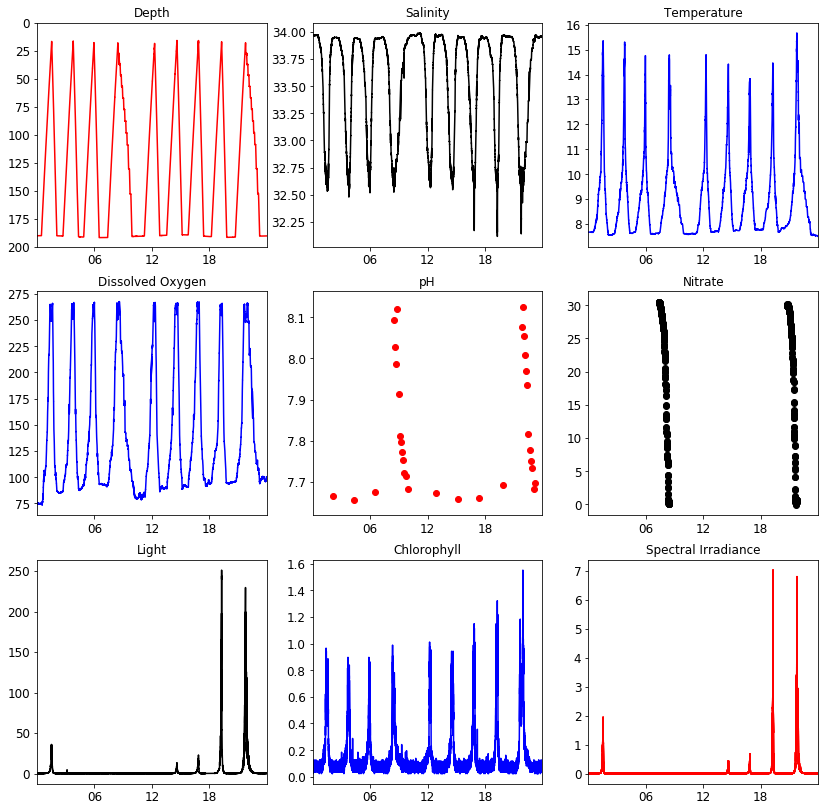

In [74]:
# ctd.seawater_pressure.plot() is a quick check plot provided samples are evenly spaced in time
#   Better: plot each measurement against its time coordinate
n = 9; rn = range(n); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
a[0,0].plot(ctdF.time, ctdF.seawater_pressure, color='r');                         a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.practical_salinity, color='k');                        a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.seawater_temperature, color='b');                      a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.corrected_dissolved_oxygen, color='b');                a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');                a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, \
        nitrateF.salinity_corrected_nitrate.values, color='k');                    a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                         a[2,0].set(title='Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');            a[2,1].set(title='Chlorophyll')
for i in rsi: a[2,2].plot(siF.time, siF.si0, color='r');                           a[2,2].set(title='Spectral Irradiance')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)

print('')   # also to hide the ninth chart if there were only 8 to show use: a[-1, -1].axis('off')

### Our story so far

Over a single day we have here eight scalar measurements -- including depth -- as well as *spectral irradiance* 
shown in the ninth chart featuring seven wavelength intensities. This gives a rather
complicated picture of what is happening in the upper 200 meters of the water column in the course of a single day.
Here are a few observations, one for each plot...

- depth profiles number 4 and 9 seem to have taken longer; with stops along the way back down
- profiles 7, 8 and 9 show less salty water near the surface
- the water is consistently about 8 degrees C warmer at the surface than it is at 200 meters depth
  - glodap and argo comparisons go here 
- there is more dissolved oxygen in the surface water compared to at-depth
- surface water is more alkaline
- surface water has a higher concentration of nitrates
- night seems to fall from hours 5 to 14 but this is in fact 10pm to 5am local time
- chlorophyll concentration seems to increase over the course of the daylight hours
- spectral irradiance follows the same pattern as light

Where next? It is common to consider how depth associates with the other measurements (temperature, chlorophyll etcetera)
so let's do that next. But notice this important detail: A temperature-versus-depth chart for the entire day would 
hide the fact that over the course of that day the profiler made nine separate passes through the water column from 
200 meters to near the surface and back again. We will show the data with emphasis on a particular profile selected
using a slider control. 

In [84]:
profdt = [
    (dt64('2017-08-21T00:27:30'),dt64('2017-08-21T02:05:00')),
    (dt64('2017-08-21T02:42:30'),dt64('2017-08-21T04:19:50')),
    (dt64('2017-08-21T04:52:30'),dt64('2017-08-21T06:29:50')),
    (dt64('2017-08-21T07:22:30'),dt64('2017-08-21T09:55:40')),
    (dt64('2017-08-21T11:12:40'),dt64('2017-08-21T12:49:50')),
    (dt64('2017-08-21T13:32:35'),dt64('2017-08-21T15:09:42')),
    (dt64('2017-08-21T15:47:30'),dt64('2017-08-21T17:25:00')),
    (dt64('2017-08-21T18:12:30'),dt64('2017-08-21T19:49:50')),
    (dt64('2017-08-21T20:42:30'),dt64('2017-08-21T23:16:00'))
]

depth=ctdF.seawater_pressure.to_dataset(name='depth')
depth.coords['time'] = ('time', depth.time)
depth['depth'] = (('time'), depth.depth)
depth=depth.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
depth.depth.attrs['low_value'] = 200.
depth.depth.attrs['high_value'] = 0.

salinity=ctdF.practical_salinity.to_dataset(name='salinity')
salinity.coords['time'] = ('time', salinity.time)
salinity['salinity'] = (('time'), salinity.salinity)
salinity=salinity.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
salinity.salinity.attrs['low_value'] = 32.
salinity.salinity.attrs['high_value'] = 34.

temperature=ctdF.seawater_temperature.to_dataset(name='temperature')
temperature.coords['time'] = ('time', temperature.time)
temperature['temperature'] = (('time'), temperature.temperature)
temperature=temperature.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
temperature.temperature.attrs['low_value'] = 7.
temperature.temperature.attrs['high_value'] = 16.

DO=ctdF.corrected_dissolved_oxygen.to_dataset(name='DO')
DO.coords['time'] = ('time', DO.time)
DO['DO'] = (('time'), DO.DO)
DO=DO.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
DO.DO.attrs['low_value'] = 70.
DO.DO.attrs['high_value'] = 280.

# The Datasets built above are from single DataArrays where the principle coordinate/dimension 
#   has been modified to be time (from observation index 'obs'). These Data variables are 
#   synchronized with depth as they are all produced by the same instrument (the CTD). 
# In what follows the remaining measurements ( pH, nitrate, par, fluor, si ) will require
#   their own depth Data variables; synchronized in time. These values are provided in the
#   source data files via interpolation but I discarded them for the sake of learning how to
#   do this myself. It is generally not the case that this is 'already done for you' as it 
#   is in this instance.
# Some of the subsequent Datasets are further extended by pulling (salinity, temp, DO) values
#   from the CTD. 

pH=phF.ph_seawater.to_dataset(name='pH')
pH.coords['time'] = ('time', pH.time)
pH['pH'] = (('time'), pH.pH)
pH=pH.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
pH['depth']=('time', depth.depth.sel(time=pH.time, method='nearest'))
pH.pH.attrs['low_value'] = 7.6
pH.pH.attrs['high_value'] = 8.2

nitrate=nitrateF.salinity_corrected_nitrate.to_dataset(name='nitrate')
nitrate.coords['time'] = ('time', nitrate.time)
nitrate['nitrate'] = (('time'), nitrate.nitrate)
nitrate=nitrate.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
nitrate['depth']=('time', depth.depth.sel(time=nitrate.time, method='nearest'))
nitrate['salinity']=('time', salinity.salinity.sel(time=nitrate.time, method='nearest'))
nitrate['temperature']=('time', temperature.temperature.sel(time=nitrate.time, method='nearest'))
nitrate['DO']=('time', DO.DO.sel(time=nitrate.time, method='nearest'))
nitrate.nitrate.attrs['low_value'] = 0.
nitrate.nitrate.attrs['high_value'] = 32.
nitrate.depth.attrs['low_value'] = depth.depth.attrs['low_value']
nitrate.depth.attrs['high_value'] = depth.depth.attrs['high_value']
nitrate.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
nitrate.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
nitrate.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
nitrate.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
nitrate.DO.attrs['low_value'] = DO.DO.attrs['low_value']
nitrate.DO.attrs['high_value'] = DO.DO.attrs['high_value']

par=parF.par_counts_output.to_dataset(name='par')
par.coords['time'] = ('time', par.time)
par['par'] = (('time'), par.par)
par=par.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
par['depth']=('time', depth.depth.sel(time=par.time, method='nearest'))
par['salinity']=('time', salinity.salinity.sel(time=par.time, method='nearest'))
par['temperature']=('time', temperature.temperature.sel(time=par.time, method='nearest'))
par['DO']=('time', DO.DO.sel(time=par.time, method='nearest'))
par.par.attrs['low_value'] = 0.
par.par.attrs['high_value'] = 250.
par.depth.attrs['low_value'] = depth.depth.attrs['low_value']
par.depth.attrs['high_value'] = depth.depth.attrs['high_value']
par.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
par.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
par.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
par.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
par.DO.attrs['low_value'] = DO.DO.attrs['low_value']
par.DO.attrs['high_value'] = DO.DO.attrs['high_value']

fluor=fluorF.fluorometric_chlorophyll_a.to_dataset(name='fluor')
fluor.coords['time'] = ('time', fluor.time)
fluor['fluor'] = (('time'), fluor.fluor)
fluor=fluor.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
fluor['depth']=('time', depth.depth.sel(time=fluor.time, method='nearest'))
fluor['salinity']=('time', salinity.salinity.sel(time=fluor.time, method='nearest'))
fluor['temperature']=('time', temperature.temperature.sel(time=fluor.time, method='nearest'))
fluor['DO']=('time', DO.DO.sel(time=fluor.time, method='nearest'))
fluor.fluor.attrs['low_value'] = 0.0
fluor.fluor.attrs['high_value'] = 1.6
fluor.depth.attrs['low_value'] = depth.depth.attrs['low_value']
fluor.depth.attrs['high_value'] = depth.depth.attrs['high_value']
fluor.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
fluor.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
fluor.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
fluor.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
fluor.DO.attrs['low_value'] = DO.DO.attrs['low_value']
fluor.DO.attrs['high_value'] = DO.DO.attrs['high_value']

si=siF
si['depth']=('time', depth.depth.sel(time=si.time, method='nearest'))
si.si0.attrs['low_value'] = 0.
si.si0.attrs['high_value'] = 7.

In [85]:
colorize = ['red', 'orange', 'yellow', 'green', 'lightgreen', 'cyan', 'blue', 'magenta', 'black']

argo_d = g.SetDataDirectory('ooi/argo')
argo2 = xr.open_dataset(argo_d + 'profile2.nc')
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)

def VDC(da, z, profile_index, xlabel):       # Versus-Depth Chart
    fig,axes = plt.subplots()
    fig.set_size_inches(13,9)
    axes.set(xlim=(da.low_value, da.high_value), ylim=(200., 0.), xlabel=xlabel, ylabel='Depth (meters)')
    for i in range(9):
        if i != profile_index: 
            tmp   = da.where(da.time > profdt[i][0], drop = True)
            tmp1  = tmp.where(tmp.time < profdt[i][1], drop = True)
            dtmp  = z.where(z.time >  profdt[i][0], drop = True)
            dtmp1 = dtmp.where(dtmp.time < profdt[i][1], drop = True)
            # print(tmp1, '\n\n\n', dtmp1)
            axes.plot(tmp1, dtmp1, ',', color=colorize[i])   # ',' gives small markers
    # Now the selected profile prints on top with larger markers
    tmp   = da.where(da.time > profdt[profile_index][0], drop = True)
    tmp1  = tmp.where(tmp.time < profdt[profile_index][1], drop = True)
    dtmp  = z.where(z.time >  profdt[profile_index][0], drop = True)
    dtmp1 = dtmp.where(dtmp.time < profdt[profile_index][1], drop = True)       
    axes.plot(tmp1, dtmp1, '.', color = colorize[profile_index])    # '.' larger markers
    axes.plot(a2psu.psu.values, a2psu.depth.values, 'o-', color='black')


def PlotConfigure(X_choice, profile_choice):
    profIdx = profile_choice - 1
    if   X_choice == 'depth'      : VDC(depth.depth, depth.depth, profIdx, 'depth (meters)')
    elif X_choice == 'temperature': VDC(temperature.temperature, depth.depth, profIdx, 'temperature (deg C)')
    elif X_choice == 'salinity'   : VDC(salinity.salinity, depth.depth, profIdx, 'salinity (psu)')
    elif X_choice == 'DO'         : VDC(DO.DO, depth.depth, profIdx, 'dissolved oxygen (ug/l)')
    elif X_choice == 'nitrate'    : VDC(nitrate.nitrate, nitrate.depth, profIdx, 'nitrate')
    elif X_choice == 'pH'         : VDC(pH.pH, pH.depth, profIdx, 'pH')
    elif X_choice == 'PAR'        : VDC(par.par, par.depth, profIdx, 'light (PAR)')
    elif X_choice == 'chlorophyll': VDC(fluor.fluor, fluor.depth, profIdx, 'chlorophyll')
    else                          : VDC(si.si0, si.depth, profIdx, 'spectral irradiance')
        
interact(PlotConfigure, 
         profile_choice=widgets.IntSlider(min = 1, max = 9, step = 1, value = 1, 
                    continuous_update = False, readout_format = 'd', description='profile (1-9)'),
         
         X_choice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO', 
                                               'nitrate', 'pH', 'PAR', 'spectral irradiance', 'chlorophyll'],
                                      value='temperature', description='data type', disabled = False)
        )      

interactive(children=(Select(description='data type', index=1, options=('depth', 'temperature', 'salinity', 'D…

<function __main__.PlotConfigure>

In [87]:
def XvY(x, y, xt, yt, xLbl, yLbl):
    fig,axes = plt.subplots()
    fig.set_size_inches(13,9)
    axes.set(xlim=(x.low_value, x.high_value), ylim=(y.low_value, y.high_value), xlabel=xLbl, ylabel=yLbl)
    
    # par['depth']=('time', depth.depth.sel(time=par.time, method='nearest'))

    for i in range(9):
        xtmp = x.where(xt > profdt[i][0], drop=True)
        xtmp1 = xtmp.where(xtmp.time < profdt[i][1], drop=True).values
        ytmp  = y.where(yt > profdt[i][0], drop=True)
        ytmp1  = ytmp.where(ytmp.time < profdt[i][1], drop=True).values
        axes.plot(xtmp1, ytmp1, ',', color=colorize[i]) 
        
def Caller(xChoice, yChoice):
    if xChoice == 'depth':       x = depth.depth;             xt = depth.time;       xs = 'depth (m)'
    if xChoice == 'temperature': x = temperature.temperature; xt = temperature.time; xs = 'temp (C)'
    if xChoice == 'salinity':    x = salinity.salinity;       xt = salinity.time;    xs = 'salinity (psu)'
    if xChoice == 'DO':          x = DO.DO;                   xt = DO.time;          xs = 'DO (ug/l)'
        
    if yChoice == 'depth':       y = depth.depth;             yt = depth.time;       ys = 'depth (m)'
    if yChoice == 'temperature': y = temperature.temperature; yt = temperature.time; ys = 'temp (C)'
    if yChoice == 'salinity':    y = salinity.salinity;       yt = salinity.time;    ys = 'salinity (psu)'
    if yChoice == 'DO':          y = DO.DO;                   yt = DO.time;          ys = 'DO (ug/l)'

    if yChoice == 'nitrate':     
        y  = nitrate.nitrate        
        yt = nitrate.time   
        ys = 'nitrate'

        if xChoice == 'depth':       x = nitrate.depth;       xt = nitrate.time; xs = 'depth (m)'
        if xChoice == 'temperature': x = nitrate.temperature; xt = nitrate.time; xs = 'temp (C)'
        if xChoice == 'salinity':    
            x = nitrate.salinity
            xt = nitrate.time; 
            xs = 'salinity (psu)'
        if xChoice == 'DO':          x = nitrate.DO;          xt = nitrate.time; xs = 'DO (ug/l)'
        
    if yChoice == 'PAR':         
        y  = par.par                 
        yt = par.time         
        ys = 'PAR'

        if xChoice == 'depth':       x = par.depth;       xt = par.time; xs = 'depth (m)'
        if xChoice == 'temperature': x = par.temperature; xt = par.time; xs = 'temp (C)'
        if xChoice == 'salinity':    x = par.salinity;    xt = par.time; xs = 'salinity (psu)'
        if xChoice == 'DO':          x = par.DO;          xt = par.time; xs = 'DO (ug/l)'
        
    if yChoice == 'chlor': 
        y  = fluor.fluor             
        yt = fluor.time       
        ys = 'chlor'
        if xChoice == 'depth':       x = fluor.depth;       xt = fluor.time; xs = 'depth (m)'
        if xChoice == 'temperature': x = fluor.temperature; xt = fluor.time; xs = 'temp (C)'
        if xChoice == 'salinity':    x = fluor.salinity;    xt = fluor.time; xs = 'salinity (psu)'
        if xChoice == 'DO':          x = fluor.DO;          xt = fluor.time; xs = 'DO (ug/l)'

    XvY(x, y, xt, yt, xs, ys)

interact(Caller, 
         xChoice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO'],
                                           value='salinity', description='X axis', disabled = False),
         yChoice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO', 'nitrate', 'PAR', 'chlor'],
                                           value='temperature', description='Y axis', disabled = False))

interactive(children=(Select(description='X axis', index=2, options=('depth', 'temperature', 'salinity', 'DO')…

<function __main__.Caller>

In [ ]:
fig,axes = plt.subplots()
fig.set_size_inches(10,10)
axes.invert_yaxis()
axes.set(xlim=(32.0, 34.), ylim=(70., 280.), xlabel='Salinity (psu)', ylabel='Dissolved Oxygen (ug / liter)')
for i in range(9):
    psu3 = psu2.psu_hours.where(psu2.hours > tbds[i], drop=True)
    psu4 = psu3.where(psu3.hours < tbds[i+1], drop=True).values
    DO3  = DO2.DO_hours.where(DO2.hours > tbds[i], drop=True)
    DO4  = DO3.where(DO3.hours < tbds[i+1], drop=True).values
    axes.plot(psu4, DO4, ',', color = colorlist[i]) 

In [ ]:
fig,axes = plt.subplots()
fig.set_size_inches(10,10)
axes.invert_yaxis()
axes.set(xlim=(7.0, 16.), ylim=(70., 280.), xlabel='Temperature (deg C)', ylabel='Dissolved Oxygen (ug / liter)')
for i in range(9):
    temperature3 = temperature2.temperature_hours.where(temperature2.hours > tbds[i], drop=True)
    temperature4 = temperature3.where(temperature3.hours < tbds[i+1], drop=True).values
    DO3  = DO2.DO_hours.where(DO2.hours > tbds[i], drop=True)
    DO4  = DO3.where(DO3.hours < tbds[i+1], drop=True).values
    axes.plot(temperature4, DO4, ',', color=colorlist[i]) 

In [ ]:
d.practical_salinity.plot() # This shows the tail data in the last three profiles

The following line magic harmonizes 3D figures with the Jupyter notebook.

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO5, temperature5, psu5, c=depth5)
axes.view_init(60, -30)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO5, temperature5, psu5, c=depth5)
axes.view_init(30, -60)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO5, temperature5, psu5, c=depth5)
axes.view_init(10, -90)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

In [ ]:
# help(axes.view_init)
# g.dirnou(axes)
# axes.azim
print(axes.azim, axes.elev, axes.dist)

### including ARGO drifter data

In [ ]:
# !wget ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190320_035619_7746409.tgz

In [89]:
argo1 = xr.open_dataset('data/argo_profile_1.nc')
argo2 = xr.open_dataset('data/argo_profile_2.nc')
argo2

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_HISTORY: 4, N_LEVELS: 70, N_PARAM: 3, N_PROF: 2)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object ...
    PROJECT_NAME                  (N_PROF) object ...
    PI_NAME                       (N_PROF) object ...
    STATION_PARAMETERS            (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                  (N_PROF) float64 ...
    DIRECTION                     (N_PROF) object ...
    DATA_CENTRE                   (N_PROF) object ...
    DC_REFERENCE                  (N_PROF) object ...
    DATA_STATE_INDICATOR          (N_PROF) object ...
    DATA_MODE            

In [90]:
print(argo1.LATITUDE[0], argo1.LONGITUDE[0])
print(argo2.LATITUDE[0], argo2.LONGITUDE[0], argo2.LATITUDE[1], argo2.LONGITUDE[1])

<xarray.DataArray 'LATITUDE' ()>
array(44.136)
Attributes:
    long_name:      Latitude of the station, best estimate
    standard_name:  latitude
    units:          degree_north
    valid_min:      -90.0
    valid_max:      90.0
    axis:           Y <xarray.DataArray 'LONGITUDE' ()>
array(-127.704)
Attributes:
    long_name:      Longitude of the station, best estimate
    standard_name:  longitude
    units:          degree_east
    valid_min:      -180.0
    valid_max:      180.0
    axis:           X
<xarray.DataArray 'LATITUDE' ()>
array(43.6)
Attributes:
    long_name:      Latitude of the station, best estimate
    standard_name:  latitude
    units:          degree_north
    valid_min:      -90.0
    valid_max:      90.0
    axis:           Y <xarray.DataArray 'LONGITUDE' ()>
array(-127.192)
Attributes:
    long_name:      Longitude of the station, best estimate
    standard_name:  longitude
    units:          degree_east
    valid_min:      -180.0
    valid_max:      180.0


In [91]:
print(argo1.JULD)
print(argo2.TEMP_ADJUSTED[0])
print(argo2.PRES_ADJUSTED[0])

<xarray.DataArray 'JULD' (N_PROF: 1)>
array(['2017-08-23T05:24:46.000000000'], dtype='datetime64[ns]')
Dimensions without coordinates: N_PROF
Attributes:
    long_name:      Julian day (UTC) of the station relative to REFERENCE_DAT...
    standard_name:  time
    conventions:    Relative julian days with decimal part (as parts of day)
    axis:           T
<xarray.DataArray 'TEMP_ADJUSTED' (N_LEVELS: 70)>
array([16.062, 15.978, 15.835, 12.84 , 11.611, 12.009, 10.301, 11.018, 10.565,
        9.725,  9.484,  9.03 ,  8.705,  8.436,  8.341,  8.135,  7.978,  7.779,
        7.636,  7.521,  7.372,  7.32 ,  7.262,  7.131,  7.083,  7.056,  6.992,
        6.945,  6.844,  6.66 ,  6.585,  6.503,  6.399,  6.339,  6.325,  6.306,
        6.007,  5.699,  5.774,  5.699,  5.065,  4.798,  4.615,  4.5  ,  4.483,
        4.325,  4.195,  4.049,  3.935,  3.809,  3.696,  3.539,  3.355,  3.265,
        3.119,  3.047,  2.979,  2.901,  2.762,  2.661,  2.589,  2.523,  2.451,
        2.366,  2.296,  2.2  ,  2.14 ,

In [92]:
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)
a2psu

<xarray.Dataset>
Dimensions:  (depth: 70)
Coordinates:
  * depth    (depth) float32 6.1 10.6 19.8 30.5 ... 1800.1 1850.3 1899.5 1950.1
Data variables:
    psu      (depth) float32 32.2636 32.28154 32.31345 ... 34.58297 34.58093

[(200.0, 0.0), (32.0, 34.0)]

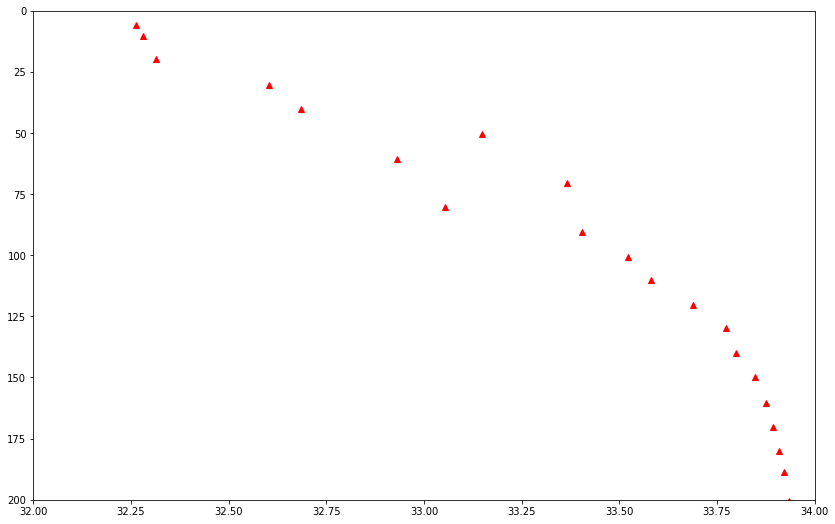

In [93]:
argo_d = g.SetDataDirectory('ooi/argo')
argo1 = xr.open_dataset(argo_d + 'profile1.nc')
argo2 = xr.open_dataset(argo_d + 'profile2.nc')
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)
f,a = plt.subplots()
f.set_size_inches(14,9)
a.plot(a2psu.psu.values, a2psu.depth.values, '^', color='red')
a.set(ylim=(200.,0.), xlim=(32.,34.))